# **Exploring the World of Generative AI**

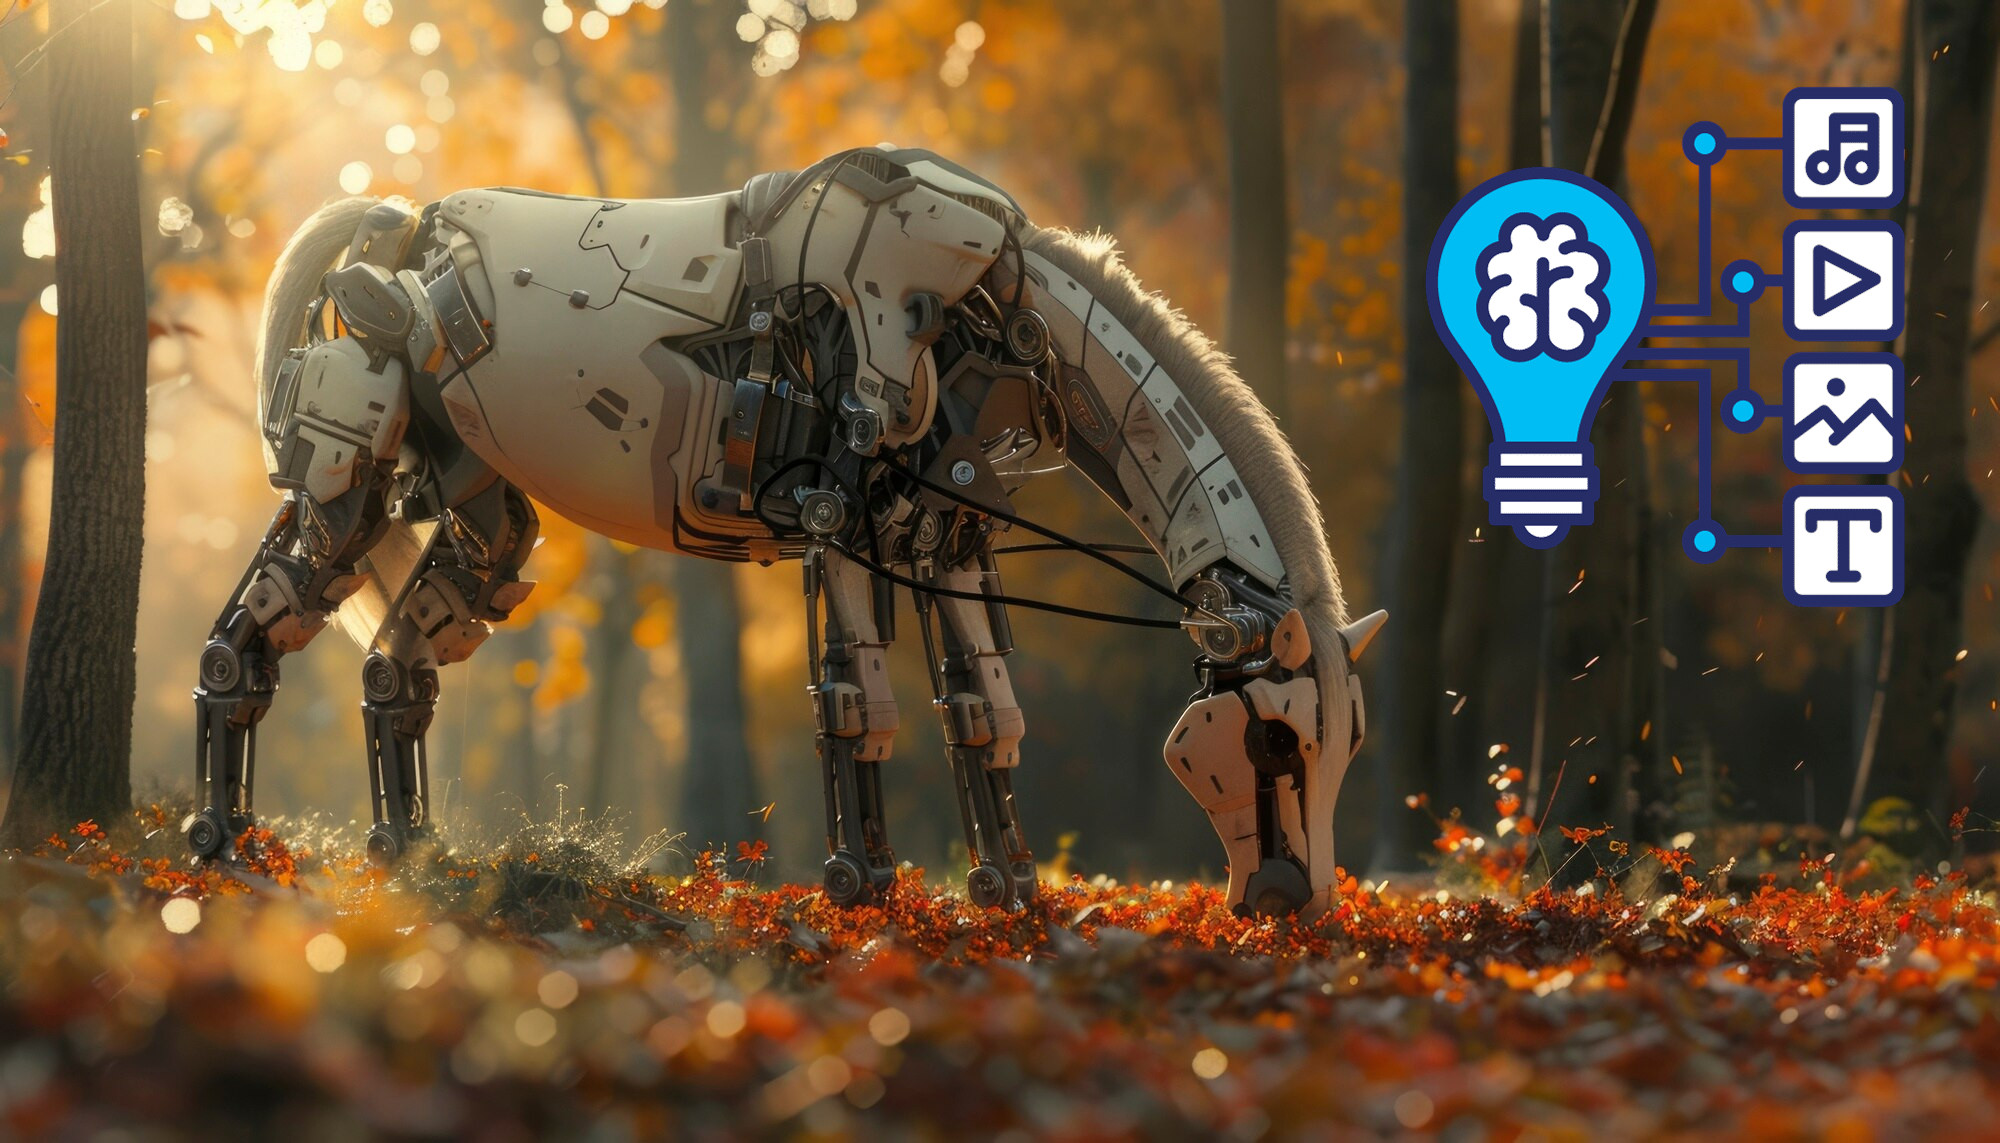

<a href="https://colab.research.google.com/github/deep-learning-indaba/indaba-pracs-2025/blob/main/practicals/Generative_AI/Part_1/Exploring_the_World_of_GenAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

© Deep Learning Indaba 2025. Apache License 2.0.

**Authors:**

- Jemma Daniel
- Rachel Catzel
- Exaucé Luweh Adjim Ngarti
- Yessine Khanfir
- Mirgahney Mohamed
- Kevin Eloff

**Reviewers:**
- Ulrich Mbou Sob
- Amel Sellami

**Introduction:**

Welcome to our hands-on practical *Exploring the World of Generative AI*—a fast-moving field reshaping how we create images, text, music, designs and more.
In this session, you'll critically examine the ethical dilemmas, explore real-world applications, and even try your hand at AI-powered image generation.

**Topics:**

Content:
- Generative Models (GANs, VAEs, diffusion, flow-matching, and autoregressive models)
- AI Ethics and Responsible Innovation

Level:
- Beginner (no coding experience required, but some high-level ML familiarity helps)
- Follow-on Generative AI practicals will require familiarity with coding and linear algebra.

**Aims/Learning Objectives:**

By the end of this practical, you will:
- Recognise impactful application areas of generative models across domains.
- Experiment with generative AI by transforming or augmenting an image.
- Try to distinguish between real and AI-generated content through visual intuition.
- Understand and reflect on key ethical tensions in the use of generative AI.

**Prerequisites:**

No coding experience required.

You will get the most out of this if you've encountered the basics of machine learning or seen models like ChatGPT, DALL·E or Stable Diffusion in action.

**Outline:**

>[Introduction to Generative Models](#scrollTo=m2s4kN_QPQVe)

>>[Installation and Imports](#scrollTo=6EqhIg1odqg0)

>>[Section 1: What are Generative Models?](#scrollTo=K0yelFcncsYL)

>>>[1.1 Real-World Applications of Generative AI](#scrollTo=7V1T7Uygddu7)

>>>>[🎨 Creative Tools & Media](#scrollTo=aHM6Io_FfI1N)

>>>>[💬 Language & Communication](#scrollTo=SE6BNUiKfbXy)

>>>>[🧫 Science & Discovery](#scrollTo=ECuBDtM1ghha)

>>>>[🕵️ Simulation & Training Environments](#scrollTo=AXiZcROxfmRo)

>>[Section 2: Interactive Examples](#scrollTo=ftluJWPWX9xO)

>>>[2.1 Image Augmentation](#scrollTo=STFjkky1m5eo)

>>>>[🤖 Time to have some fun with generative models!](#scrollTo=d76aCLjqHsij)

>>>>[🎨 Enhance your drawing with AI](#scrollTo=FKaFIholH487)

>>>[2.2 Hands-On Activity: AI or Real?](#scrollTo=w1BCSc68aW_w)

>>[Section 3: Ethical Concerns](#scrollTo=sk2CcPxKZi3V)

>>>[3.1 Hot Topic Cards](#scrollTo=dRjyzj0vagRc)

>>>>[🌍 Environmental Cost of Generative AI](#scrollTo=KWdAePF6KSDB)

>>>>[👥 Bias in Generation](#scrollTo=3917c42a)

>>>>[🕵️ Synthetic Reality and Deepfakes](#scrollTo=0362f619)

>>>>[🏫 Generative AI in Education](#scrollTo=476117d1)

>>>>[💼 Generative AI and the Future of Work](#scrollTo=421e6805)

>>>>[🤔 Explainability and Trust](#scrollTo=BduHYkvl4I5p)

>>>>[🔏 Ownership, Authorship and Copyright](#scrollTo=Q56R6UiS4tRH)

>>>>[🌍 Global Equity and Accessibility](#scrollTo=IKN1RUCn5J4W)

>>>>[🔓 Openness vs Safety](#scrollTo=krcbgoCz5fOi)

>>>[3.2 Class Debates](#scrollTo=cKrIrtdj_Z7j)

>>[Conclusion](#scrollTo=fV3YG7QOZD-B)

>>[Feedback](#scrollTo=o1ndpYE50BpG)



**Before you start:**

1. Join a group of 3–4 if you haven't already.
2. Open this notebook in Colab (not just preview).
3. Check that you can run cells and display images.
4. *(Optional)* Be ready to use a selfie or sketch of your own.

For this practical, you will need to use a GPU if you are on Google Colab to generate images. To do this, go to the "Runtime" menu in Colab, select "Change runtime type" and then in the popup menu, choose "GPU" in the "Hardware accelerator" box.

Another important step you need to do. You cannot continue without this!
- Go to `Tools > Settings > Miscellaneous`
- Make sure the options for `Kitty mode` and `Corgi mode` are checked!

## Installation and Imports

We recommend running the notebook on [Google Colab](https://colab.research.google.com/). If you want to run the notebook locally please use Python 3.10 or later.

In [1]:
# @title Install and import required packages. (Run Cell)
%%capture
try:
    import google.colab
except ImportError:
    !pip install diffusers transformers accelerate torch torchvision pillow matplotlib
!pip install controlnet-aux opencv-python # pillow matplotlib

import torch
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
from diffusers import StableDiffusionControlNetPipeline, StableDiffusionPipeline, ControlNetModel
import cv2
import numpy as np

In [2]:
# @title Helper Functions. (Run Cell)

device = "cuda" if torch.cuda.is_available() else "cpu"

if device == "cpu":
    print("We couldn't access the GPU, please go to the \"Runtime\" menu in Colab, select \"Change runtime type\" and then in the popup menu, choose \"GPU\" in the \"Hardware accelerator\"")

print("Loading image generation models... Start reading the next section while this loads!")

# --- Load image generation models

# Load ControlNet for Canny edge detection
controlnet = ControlNetModel.from_pretrained(
    "lllyasviel/sd-controlnet-canny",
    torch_dtype=torch.float16 if device == "cuda" else torch.float32
)

# Load Stable Diffusion pipeline
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    controlnet=controlnet,
    torch_dtype=torch.float16 if device == "cuda" else torch.float32,
    safety_checker=None,
    requires_safety_checker=False
)
pipe = pipe.to(device)

base_pipe = StableDiffusionPipeline(
    vae=pipe.vae,
    text_encoder=pipe.text_encoder,
    tokenizer=pipe.tokenizer,
    unet=pipe.unet,  # This is still shared with ControlNet, but works.
    scheduler=pipe.scheduler,
    safety_checker=None,
    feature_extractor=None,
    requires_safety_checker=False
)
base_pipe = base_pipe.to(device)

print("Models loaded successfully!")

# --- Define image generation helper functions

def download_image_from_url(url):
    """Download image from URL"""
    # Use headers to prevent rate limiting
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }

    try:
        response = requests.get(url, headers=headers, stream=True)
        response.raise_for_status()  # Raise an exception for bad status codes

        # Open image from bytes
        image = Image.open(BytesIO(response.content))
        return image
    except Exception as e:
        print(f"Error downloading image from {url}: {e}")
        raise

def load_image_smart(image_input):
    """Load image from either file path or URL"""
    if isinstance(image_input, str):
        if image_input.startswith(('http://', 'https://')):
            # It's a URL
            return download_image_from_url(image_input)
        else:
            # It's a file path
            return Image.open(image_input).convert('RGB')
    elif isinstance(image_input, Image.Image):
        # It's already a PIL Image
        return image_input.convert('RGB')
    else:
        raise ValueError("image_input must be a string (path or URL) or PIL Image")

def process_sketch(image_input):
    # Load and resize image (works with paths, URLs, or PIL Images)
    image = load_image_smart(image_input)
    image = image.resize((512, 512))

    # Convert to numpy for Canny detection
    image_np = np.array(image)

    # Apply Canny edge detection
    canny = cv2.Canny(image_np, 100, 200)
    canny_image = Image.fromarray(canny)

    return image, canny_image

def generate(sketch_input, prompt, seed):
    # Process the sketch
    original, canny = process_sketch(sketch_input)

    generator = torch.manual_seed(seed)

    # Generate enhanced image
    result = pipe(
        prompt=prompt,
        image=canny,
        num_inference_steps=120,
        guidance_scale=15
    ).images[0]

    return original, canny, result

def generate_from_prompt(prompt, seed):
    generator = torch.manual_seed(seed)

    # Generate enhanced image
    result = base_pipe(
        prompt=prompt,
        num_inference_steps=120,
        guidance_scale=15
    ).images[0]

    return result

def generate_and_display_sculpture(input_path, seed):
    # Generate the enhanced version
    original, edges, enhanced = generate(
        input_path,
        "ancient roman sculpture",
        seed,
        )

    # Display results
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(original)
    axes[0].set_title("Original")
    axes[0].axis('off')

    axes[1].imshow(edges, cmap='gray')
    axes[1].set_title("Edges")
    axes[1].axis('off')

    axes[2].imshow(enhanced)
    axes[2].set_title("Generated")
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

    # Save the result
    enhanced.save("generated.jpg")
    print("Output saved as 'generated.jpg'")

def generate_and_display_enhanced_sketch(input_path, prompt, seed):
    # Generate the enhanced version
    original, edges, enhanced = generate(input_path, prompt, seed)

    # Display results
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(original)
    axes[0].set_title("Original")
    axes[0].axis('off')

    axes[1].imshow(edges, cmap='gray')
    axes[1].set_title("Edges")
    axes[1].axis('off')

    axes[2].imshow(enhanced)
    axes[2].set_title("Generated")
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

    # Save the result
    enhanced.save("generated.jpg")
    print("Output saved as 'generated.jpg'")

print("\nDownloading example images")
# Download example images
!curl -L https://i.imgur.com/hEyFAoA.png -o selfie.png;
!curl -L https://i.imgur.com/iY7xaJb.png -o sketch.png;

Loading image generation models... Start reading the next section while this loads!


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/920 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Models loaded successfully!

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  332k  100  332k    0     0  2076k      0 --:--:-- --:--:-- --:--:-- 2080k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  130k  100  130k    0     0  1225k      0 --:--:-- --:--:-- --:--:-- 1223k


## Section 1: What are Generative Models?

Generative AI refers to models that can create new data—images, text, music, protein structures, even code—by learning patterns from existing data. Unlike traditional models that just classify or predict, generative models go a step further: they imagine.

👉 In this practical, we'll experiment with a diffusion model to enhance our own images, attempt to discriminate between real and AI-generated images, and discuss the ethical questions that come with such powerful tools.

Later sessions will dive deeper into:

- 🟢 Probabilistic Modelling in depth, including GANs (Generative Adversarial Networks) and VAEs (Variational Autoencoders)
- 🟢 Diffusion Models
- 🟢 Flow-matching Models

But first, let's look at some of the most impressive (and important) uses of generative AI so far 👇

---

### 1.1 Real-World Applications of Generative AI

#### 🎨 Creative Tools & Media
Generative models support artists, designers and creators with new tools to express ideas—or co-create with AI.

- 🖼️ **Image generation** (e.g. Stable Diffusion): Create photorealistic images or illustrations from text prompts or sketches.

> 📌 *Hands-on*: Later in this notebook, you’ll use a diffusion model to remix or enhance your own image!

- 🎼 **Music & sound** (e.g. Riffusion, MusicGen): Models that turn text into music or generate new soundscapes for games, films and therapy apps.

- 🪡 **Fashion design & architecture**: Generative tools are used to suggest new clothing designs or building layouts from high-level goals (e.g. “maximise natural light”).



#### 💬 Language & Communication
Generative language models are transforming how we read, write and communicate.

- ✍️ **Writing assistants** (e.g. ChatGPT, Claude): Help people draft emails, essays, or poetry—or translate between languages and styles.

- 🧾 **Code generation** (e.g. GitHub Copilot, Codex): Speeds up software development by generating or completing code based on docstrings or prompts.

- 🗣️ **Conversational agents**: Used in education, mental health, customer support—even AI companions or tutors.

#### 🧫 Science & Discovery

Generative AI is speeding up scientific breakthroughs—by designing molecules, simulating experiments, and even generating new research directions.

- 🧬 **Protein sequence generation** (e.g. ESM, ProtGPT2): Generative protein language models create novel amino acid sequences that can lead to new proteins with potentially useful functions, accelerating protein design and synthetic biology.
- 🧪 **Small molecule generation** (e.g. GENTRL): AI can suggest brand-new molecules with desired properties (such as low toxicity or strong binding) for drug design or materials science.
- 🧭 **Climate & materials discovery**: Generative models help design materials with specific strengths, conductivity or heat resistance—key for clean energy tech, semiconductors and beyond.

#### 🕵️ Simulation & Training Environments
Generative models can build synthetic environments, scenarios, and data for testing and training systems—especially where real data is scarce or sensitive.

- 🚗 **Autonomous vehicle simulation**: Generate realistic driving scenarios for self-driving cars to train on (e.g. rare weather or edge cases).

- 🚑 **Medical training simulations**: AI can generate realistic patient cases—symptoms, test results or even radiology scans—to help doctors and med students practise diagnosis and decision-making. Some systems even simulate patient dialogue to train bedside manner and communication skills.

- 🎓 **Language learning partners**: AI-generated conversation partners can simulate different fluency levels, accents or personalities to help students practise foreign languages in varied, immersive contexts.

---

## Section 2: Interactive Examples

In this interactive session, you'll experience the incredible power of diffusion models firsthand.
We will first take a look at using [`runwayml/stable-diffusion-v1-5`](https://huggingface.co/stable-diffusion-v1-5/stable-diffusion-v1-5) available on HuggingFace.

_Note: we will not go into the implementation details in this practical! Please join us for the following practicals if you would like a deep dive on how these models really work!_

To start off we can simply provide a prompt of anything you want the model to generate!

Example prompts:
- "A giant baobab tree, in the style of Starry Night painted by Van Gogh"
- "An astronaut riding a lion on Mars"
- "Baobab tree logo"


  0%|          | 0/120 [00:00<?, ?it/s]

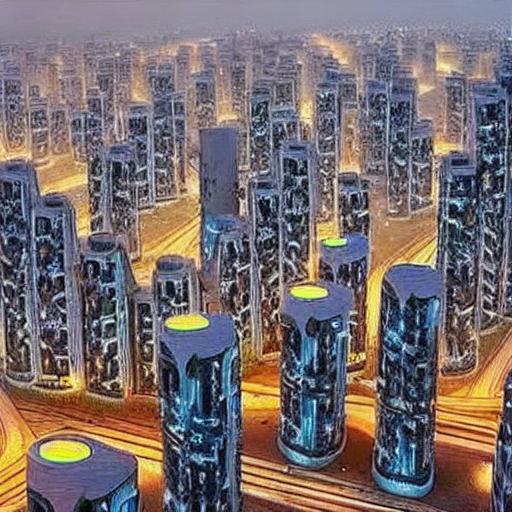

In [3]:
prompt = "beautiful futuristic African city, tall African buildings"
seed = 42  # Change this seed to generate new versions!

generate_from_prompt(prompt, seed)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Now isn't that cool? We were able to take a text prompt and produce a completely new image!

**Group task**
- What sort of cool images can you come up with?
- Stable Diffusion is trained on a lot of images, do you think you could come up with an image that wouldn't be in the training set? How would the model perform?
  - We are not exactly sure what the model has or has not seen, we just know it is many terabytes of images sourced from the internet. This includes public domain images, licensed datasets, and images uploaded by users on various platforms.

### 2.1 Image Augmentation

In this section we are going to explore fun and interesting ways to control these models.
You'll be able to generate images of ancient sculptures of yourself, and
you'll draw simple sketches and watch as AI transforms them into enhanced artwork!



#### 🤖 Time to have some fun with generative models!

🏛 Ever wondered what an ancient sculpture of yourself might look like?

Follow the steps below 👇

**Option 1: Use the default photo**

We've provided a photo of Yessine, one of our prac developers!

✅ Just run the next cell—no upload needed.

**Option 2: Upload your own photo (optional)**

If you'd like to try this with your own selfie or drawing, you can upload it to the Google Colab file explorer.

<!-- >⚠️ **Important Privacy Note:**
> Anything you upload to Imgur is public by default. This means your image will be accessible to anyone with the link, and may be indexed online. We recommend uploading a drawing, cartoon avatar or non-sensitive photo. -->

🔧 **Upload Instructions**

1. 📁 Open the file explorer on the left with the file icon
2. 🖱️ Click on the file upload button (up arrow) or right click the explorer and select "Upload".
3. 💻 Select a photo from your local device and upload it!
4. ✅ The file should be visible in your Colab file explorer, it should end in `.png` or `.jpg` or similar!
5. 📋 Update the filename in the `photo_path` below.

_Note: you can optionally link to an image online!_

  0%|          | 0/120 [00:00<?, ?it/s]

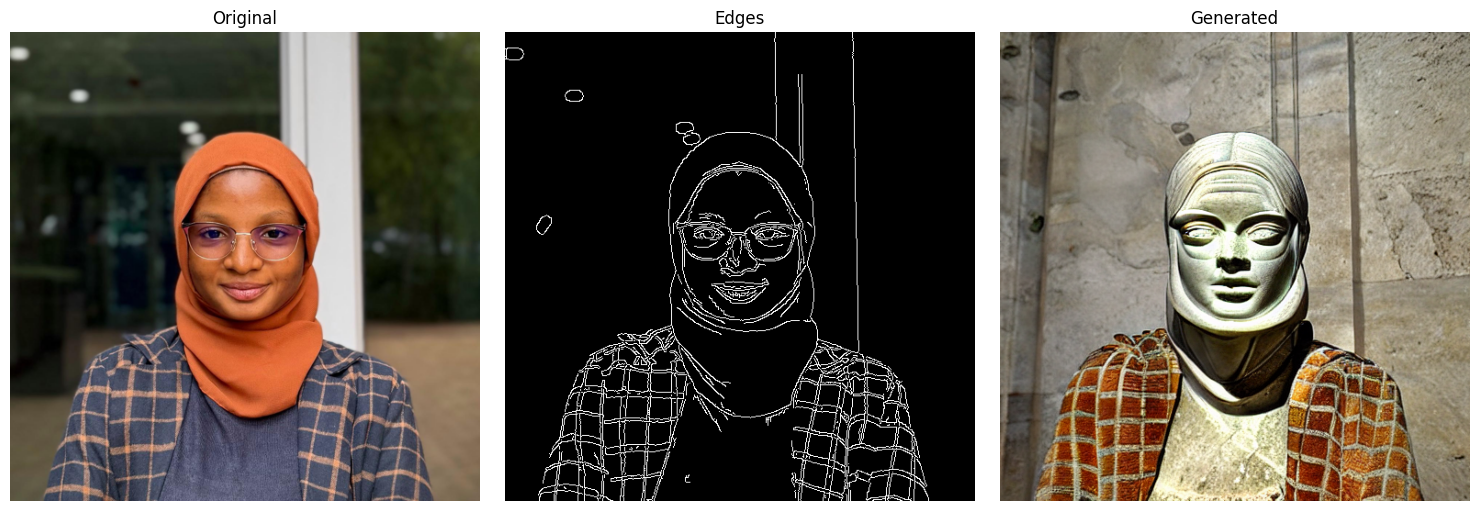

Output saved as 'generated.jpg'


In [4]:
photo_path = "Adiza_HeadShot.jpg"
seed = 26  # Change this seed to generate new versions!

generate_and_display_sculpture(photo_path, seed)

#### 🎨 Enhance your drawing with AI

Ready to turn your sketch into a stylised image using a diffusion model?

Follow the steps below 👇

1. ✍ Write a brief prompt describing what you want the final image to look like
E.g., "A futuristic city skyline at sunset" or "A pink cartoon of a lion"
2. 🖼️ Upload a simplified sketch of your idea (see the image upload instructions above 👆)
3. 📁 Paste the filename of your sketch in the sketch_path variable
4. ▶️ Run the cell below to see how the AI interprets and enhances your drawing!

  0%|          | 0/120 [00:00<?, ?it/s]

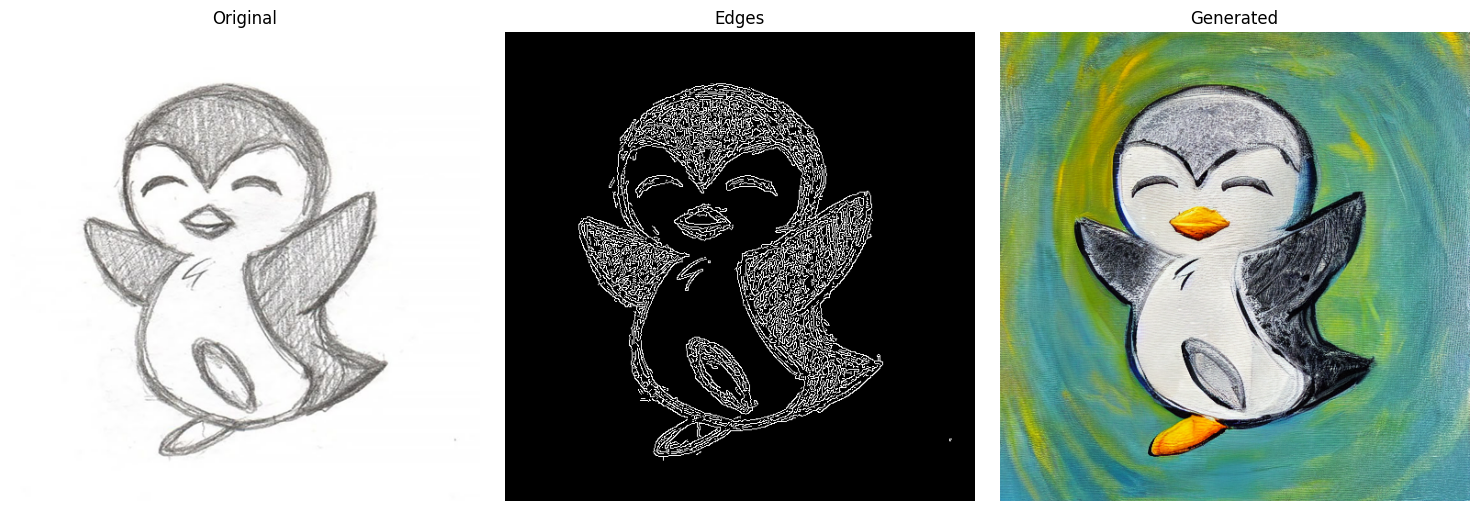

Output saved as 'generated.jpg'


In [ ]:
prompt = "painting of a happy penguin"
sketch_path = "sketch.png"
seed = 52  # Change this seed to generate new versions!

generate_and_display_enhanced_sketch(sketch_path, prompt, seed)

---

### 2.2 Hands-On Activity: AI or Real?

Can you tell the difference between real photos and AI-generated images?

We'll show you a series of images. For each one, decide:  
**Is this image generated by a human or by an AI model?**

👇 Make your best guess—no Googling!


<details>
<summary>📑 Image Sources</summary>

- [AI or Not AI: Can You Spot the Real Photos?](https://www.cnet.com/pictures/ai-or-not-ai-can-you-spot-the-real-photos/)
- [Real or AI? The Game](https://real-or-fake-the-ai-game.onrender.com/)

</details>

#### 🖼️ Image #1

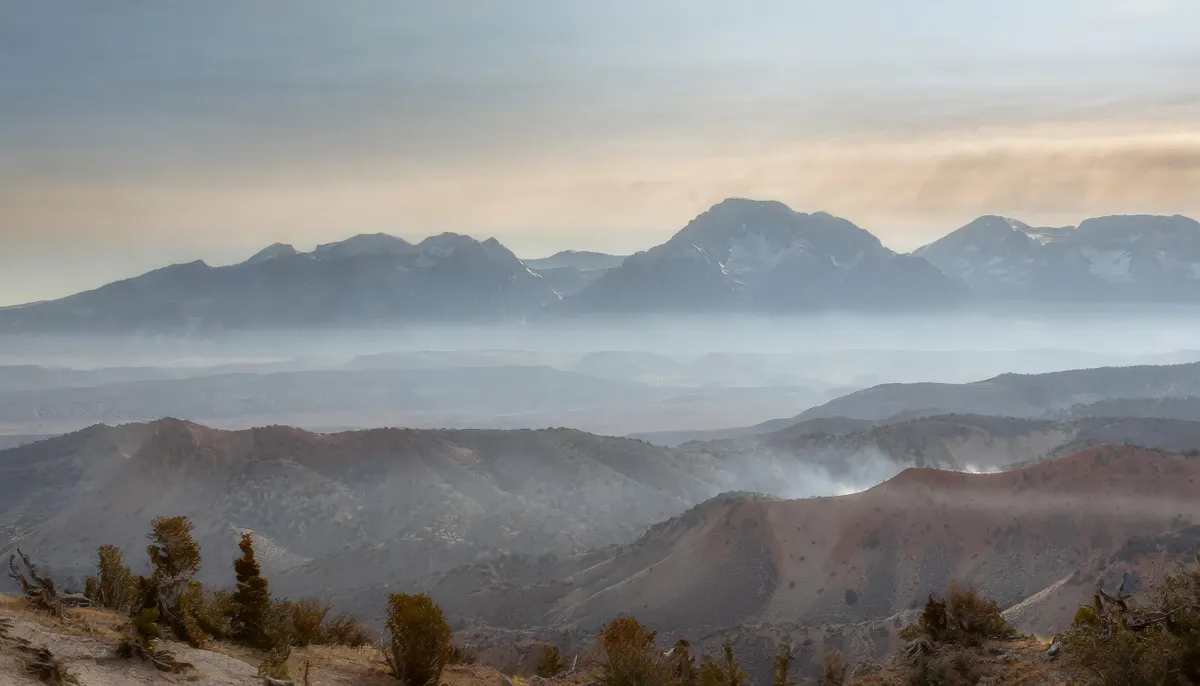

**What do you think?**  
- [ ] 🤖 AI-Generated  
- [ ] 📷 Real Photo

⬇️ Use the dropdown below to lock in your guess.


In [ ]:
#@title 🔽 Your Guess for Image #1
your_guess_1 = "Select"  #@param ["Select", "AI", "Real"]

if your_guess_1 != "Select":
    print(f"✅ You guessed: {your_guess_1}")


<details>
<summary>🟢 Reveal the Answer</summary>

✅ **This is an AI-generated image.**

</details>


#### 🖼️ Image #2

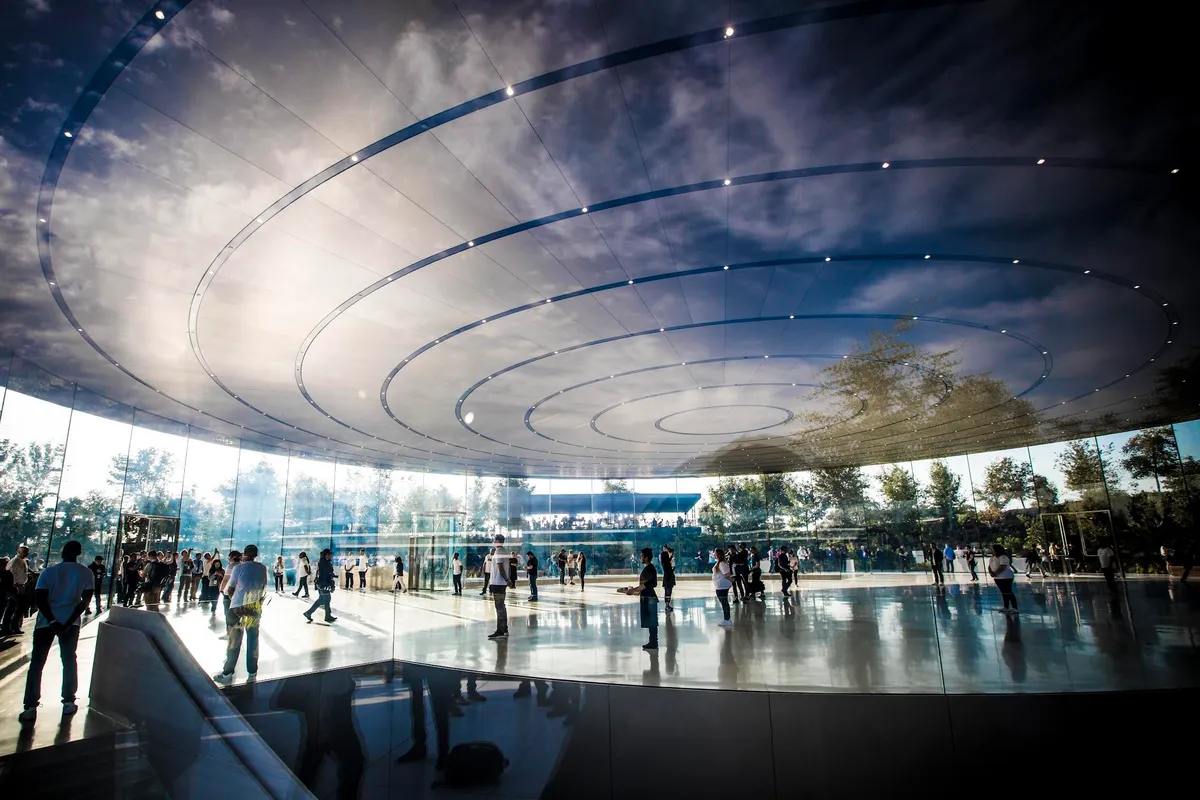

**What do you think?**  
- [ ] 🤖 AI-Generated  
- [ ] 📷 Real Photo

⬇️ Use the dropdown below to lock in your guess.


In [ ]:
#@title 🔽 Your Guess for Image #2
your_guess_2 = "Select"  #@param ["Select", "AI", "Real"]

if your_guess_2 != "Select":
    print(f"✅ You guessed: {your_guess_2}")


<details>
<summary>🟢 Reveal the Answer</summary>

✅ **This is a real image.**

</details>


#### 🖼️ Image #3

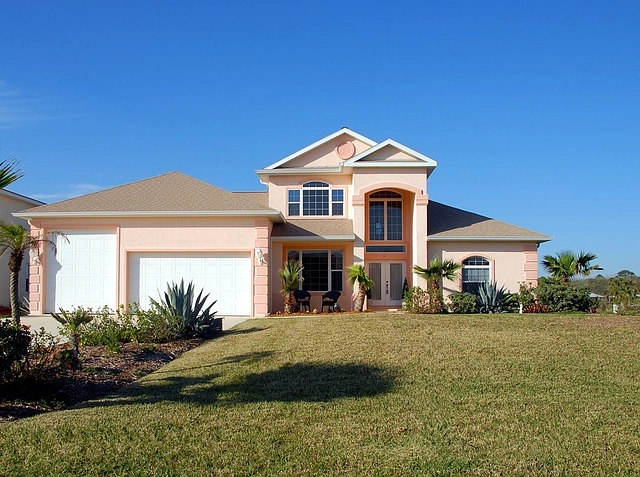

**What do you think?**  
- [ ] 🤖 AI-Generated  
- [ ] 📷 Real Photo

⬇️ Use the dropdown below to lock in your guess.


In [ ]:
#@title 🔽 Your Guess for Image #3
your_guess_3 = "Select"  #@param ["Select", "AI", "Real"]

if your_guess_3 != "Select":
    print(f"✅ You guessed: {your_guess_3}")


<details>
<summary>🟢 Reveal the Answer</summary>

✅ **This is a real image.**

</details>


#### 🖼️ Image #4

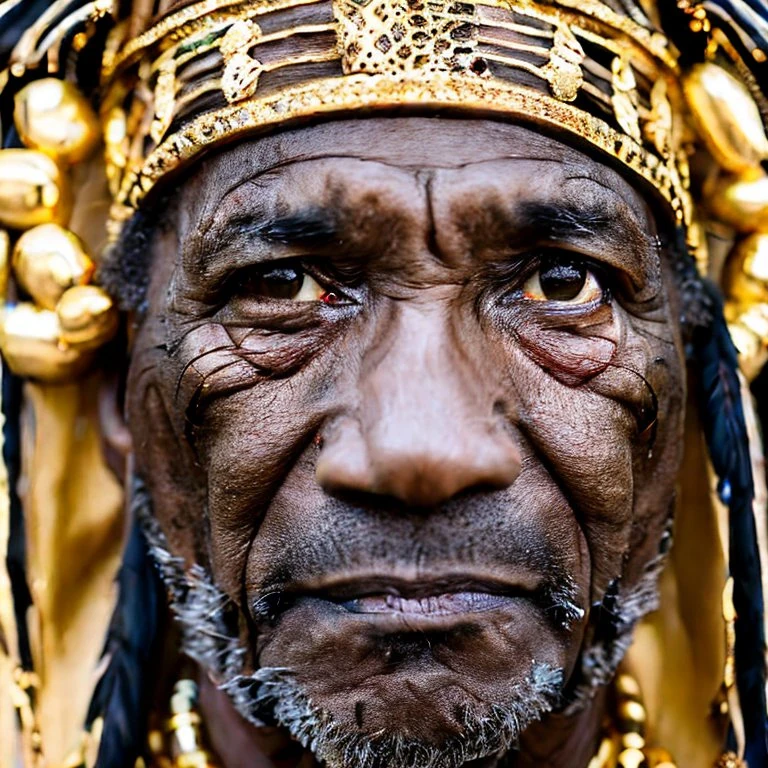

**What do you think?**  
- [ ] 🤖 AI-Generated  
- [ ] 📷 Real Photo

⬇️ Use the dropdown below to lock in your guess.


In [ ]:
#@title 🔽 Your Guess for Image #4
your_guess_4 = "Select"  #@param ["Select", "AI", "Real"]

if your_guess_4 != "Select":
    print(f"✅ You guessed: {your_guess_4}")


<details>
<summary>🟢 Reveal the Answer</summary>

✅ **This is an AI-generated image.**

</details>


#### 🖼️ Image #5

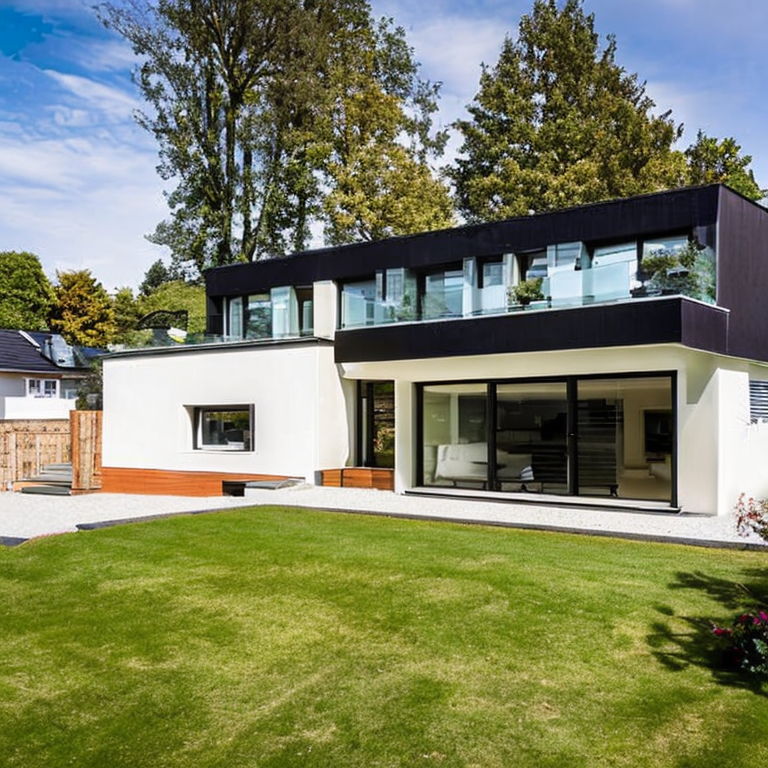

**What do you think?**  
- [ ] 🤖 AI-Generated  
- [ ] 📷 Real Photo

⬇️ Use the dropdown below to lock in your guess.


In [ ]:
#@title 🔽 Your Guess for Image #5
your_guess_5 = "Select"  #@param ["Select", "AI", "Real"]

if your_guess_5 != "Select":
    print(f"✅ You guessed: {your_guess_5}")


<details>
<summary>🟢 Reveal the Answer</summary>

✅ **This is an AI-generated image.**

</details>


#### 🖼️ Image #6

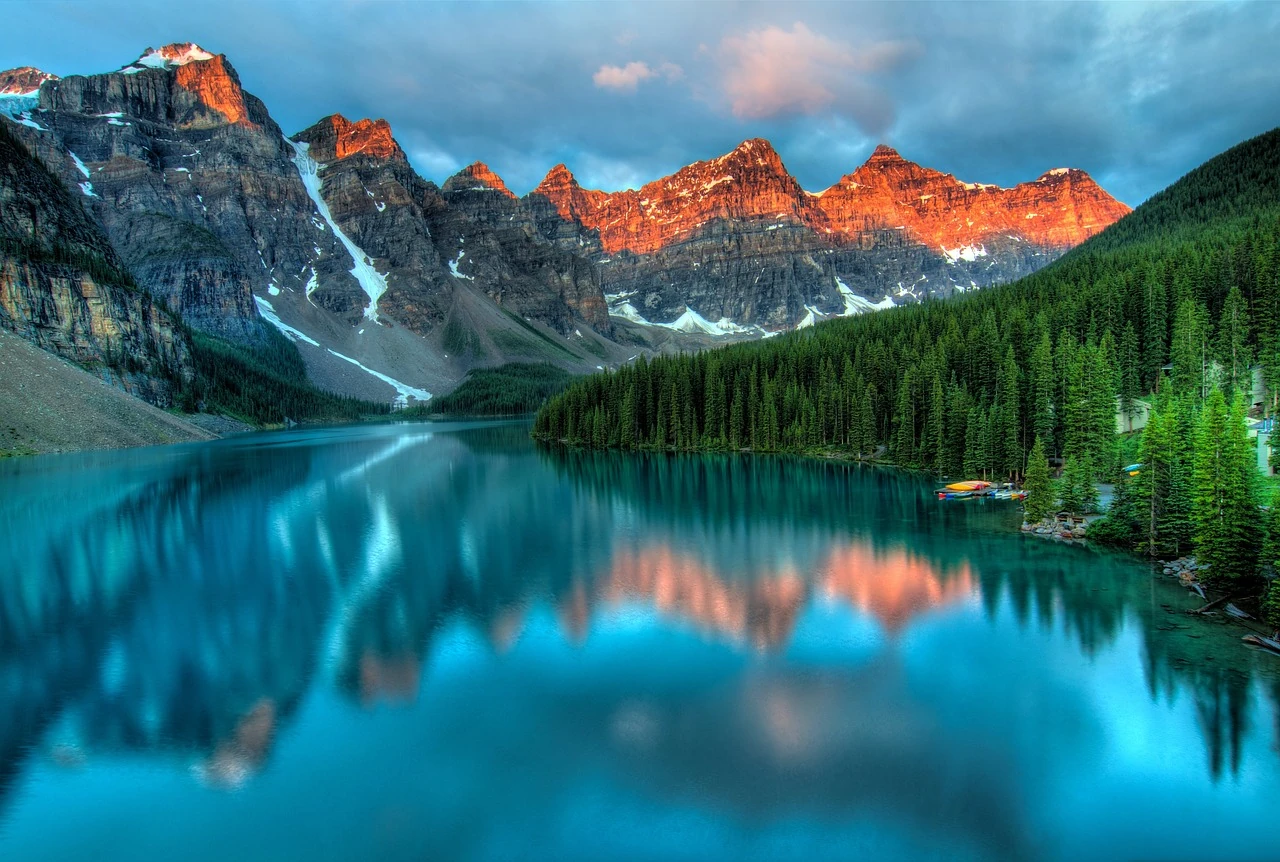

**What do you think?**  
- [ ] 🤖 AI-Generated  
- [ ] 📷 Real Photo

⬇️ Use the dropdown below to lock in your guess.


In [ ]:
#@title 🔽 Your Guess for Image #6
your_guess_6 = "Select"  #@param ["Select", "AI", "Real"]

if your_guess_6 != "Select":
    print(f"✅ You guessed: {your_guess_6}")


<details>
<summary>🟢 Reveal the Answer</summary>

✅ **This is a real image.**

</details>


#### 🖼️ Image #7

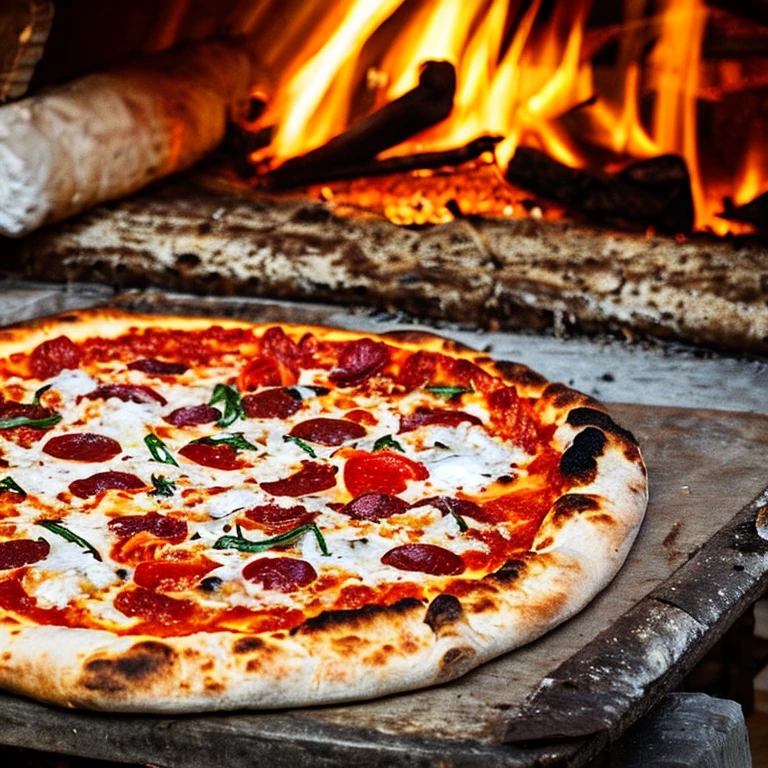

**What do you think?**  
- [ ] 🤖 AI-Generated  
- [ ] 📷 Real Photo

⬇️ Use the dropdown below to lock in your guess.


In [ ]:
#@title 🔽 Your Guess for Image #7
your_guess_7 = "Select"  #@param ["Select", "AI", "Real"]

if your_guess_7 != "Select":
    print(f"✅ You guessed: {your_guess_7}")


<details>
<summary>🟢 Reveal the Answer</summary>

✅ **This is an AI-generated image.**

</details>


#### 🖼️ Image #8

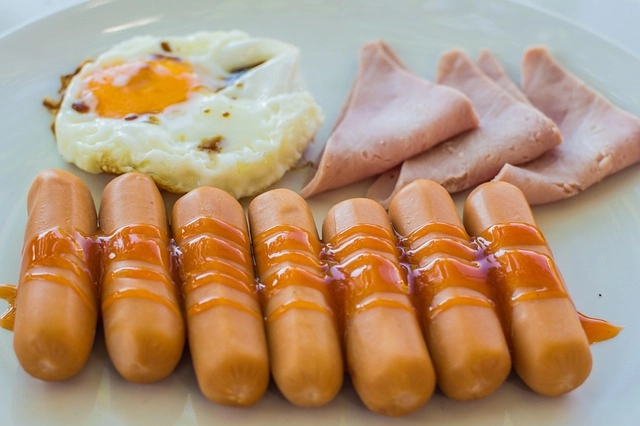

**What do you think?**  
- [ ] 🤖 AI-Generated  
- [ ] 📷 Real Photo

⬇️ Use the dropdown below to lock in your guess.


In [ ]:
#@title 🔽 Your Guess for Image #8
your_guess_8 = "Select"  #@param ["Select", "AI", "Real"]

if your_guess_8 != "Select":
    print(f"✅ You guessed: {your_guess_8}")


<details>
<summary>🟢 Reveal the Answer</summary>

✅ **This is a real image.**

</details>


---

## Section 3: Ethical Concerns

### 3.1 Hot Topic Cards

You'll spend the next section engaging with current ethical debates in generative AI.

Each card includes:
- A short context blurb
- 🥕 *Food for Thought* checkboxes to spark reflection
- 🎭 A roleplay scenario to bring the issue to life
- 📚 Sources (folded into collapsible sections)

👉 Break into groups of 3–4 and dive into the following GenAI hot topics together.

Let's get started 👇

#### 🌍 Environmental Cost of Generative AI

Large-scale generative models—especially those for image and video—consume vast amounts of electricity and water.
Generating one image with Stable Diffusion XL uses as much energy as charging a smartphone. GPT-4 may have consumed over $5 million worth of electricity during training, and training BERT emitted as much CO₂ as taking a transcontinental flight, and models often have shelf lives of mere weeks.
As models grow, so do energy and cooling costs. ChatGPT uses about 5x the energy of a typical search engine query. Water use is also a concern: for each kWh consumed by data centers, around 2L of water may be needed for cooling.

##### 🥕 Food for Thought

- 🟢 Should companies have to disclose the carbon emissions generated from their AI usage?
- 🟢 How can we accurately quantify the environmental cost of generative AI?
- 🟢 How does the energy cost of using a generative model compare to getting a human to do the task?
- 🟢 When do the societal benefits of AI usage outweigh the environmental costs—if at all?

##### 🎭 Scenario

> You're designing an LLM for rural health diagnostics. Your model improves outcomes—but running inference in the cloud is energy-intensive.
Meanwhile, your grant funder wants the model retrained monthly for performance.
Can you justify the compute? What trade-offs would you make?

<details>
<summary>📑 Sources & Further Reading</summary>

- [Explained: Generative AI's environmental impact](https://news.mit.edu/2025/explained-generative-ai-environmental-impact-0117)
- [The growing energy footprint of artificial intelligence](https://www.sciencedirect.com/science/article/pii/S2542435123003653)
- [As use of AI soars, so does the energy and water it requires](https://e360.yale.edu/features/artificial-intelligence-climate-energy-emissions)
- [The rising costs of training frontier AI models](https://arxiv.org/abs/2405.21015)
- [Power hungry processing: Watts Driving the cost of AI deployment?](https://arxiv.org/abs/2311.16863)
- [Energy and policy considerations for deep learning in NLP](https://arxiv.org/abs/1906.02243)
- [EU Artificial Intelligence Act](https://eur-lex.europa.eu/legal-content/EN/TXT/PDF/?uri=OJ:L_202401689)

</details>

#### 👥 Bias in Generation

Generative models reflect the biases in their training data.
ChatGPT tends to use language that sounds more caring and group-focused when writing about women, and more confident and action-focused when writing for men.
LLMs may recommend less aggressive medical treatment for racial minorities, and image models like DALL·E underrepresent women and dark-skinned individuals in professional contexts.

Biases are most visible in single-sample generation, where the 'most likely' answer reinforces stereotypes. More diversity appears when multiple outputs are sampled.

##### 🥕 Food for Thought

- 🟢 Is this a model/data issue or a prompt design issue?
- 🟢 Should generative models automatically diversify single-sample outputs?
- 🟢 How should these biases be disclosed or mitigated at deployment?

##### 🎭 Scenario

> A venture capitalist uses an image model to generate “a tech CEO for a Nigerian startup.”
Every result is a man. When asked for 10 examples, women appear.
Your team is developing the model. Do you fix the prompt? Change the output defaults? Or restructure the dataset?

<details>
<summary>📑 Sources & Further Reading</summary>



- [What's in a name? Experimental evidence of gender bias in recommendation letters generated by ChatGPT](https://pmc.ncbi.nlm.nih.gov/articles/PMC10951834/)
- [Unmasking and quantifying racial bias of large language models in medical report generation](https://pmc.ncbi.nlm.nih.gov/articles/PMC11387737/)
- [Gender bias in generative artificial intelligence text-to-image depiction of medical students](https://journals.sagepub.com/doi/10.1177/00178969241274621)
- [Gender and ethnicity bias in generative artificial intelligence text-to-image depiction of pharmacists](https://academic.oup.com/ijpp/article/32/6/524/7748890?login=false)



</details>

#### 🕵️ Synthetic Reality and Deepfakes

Deepfakes are highly realistic AI-generated images, videos or audio clips that mimic real people.
They have artistic and accessibility benefits—but also threaten privacy, trust and civil discourse.
They can sway elections, fake legal evidence or harass individuals. Legal frameworks are struggling to catch up.

##### 🥕 Food for Thought

- 🟢 Should consent laws be extended to cover likeness and voice?
- 🟢 Who should be liable for harm caused by a synthetic clone of a real person?
- 🟢 How can we build and preserve public trust in media and institutions?

##### 🎭 Scenario

> You work for a global social media company. A video is flagged as a likely deepfake—but it's being widely shared and praised.
It shows a climate activist giving a powerful, emotional speech. The real activist says it's fake, but “they agree with the message.”
Should you take it down?

<details>
<summary>📑 Sources & Further Reading</summary>

- [Threat of deepfakes to the criminal justice system: a systematic review](https://link.springer.com/article/10.1186/s40163-024-00239-1)
- [The potential effects of deepfakes on news media and entertainment](https://link.springer.com/article/10.1007/s00146-024-02072-1)
- [Unmasking deepfakes: a multidisciplinary examination of social impacts and regulatory responses](https://link.springer.com/article/10.1007/s42454-025-00060-4)

</details>

#### 🏫 Generative AI in Education

Generative AI is already reshaping education: lesson planning, feedback, content generation.
It can support diverse learners—but may also promote shortcutting, critical-thinking erosion or plagiarism.
OECD policy frameworks stress the importance of transparency, privacy and equitable access.

##### 🥕 Food for Thought

- 🟢 Should generative AI be allowed in assessments with disclosure?
- 🟢 What restrictions or guardrails should educators put in place?
- 🟢 How might GenAI affect skills like reasoning, creativity and resilience?

##### 🎭 Scenario

> A school district deploys a custom GenAI tutor for all students. It generates explanations, sample answers and even draft essays.
Three months in, performance improves—but students show reduced independent problem-solving.
What interventions might you suggest?

<details>
<summary>📑 Sources & Further Reading</summary>

- [Your brain on ChatGPT: Accumulation of cognitive debt when using an AI assistant for essay writing task](https://arxiv.org/abs/2506.08872)
- [OECD Digital Education Outlook 2023](https://www.oecd.org/en/publications/oecd-digital-education-outlook-2023_c74f03de-en.html)
- [A systematic review of generative AI for teaching and learning practice](https://www.mdpi.com/2227-7102/14/6/636)
- [Generative AI and future education: a review, theoretical validation, and authors' perspective on challenges and solutions](https://pmc.ncbi.nlm.nih.gov/articles/PMC11622955/)

</details>

#### 💼 Generative AI and the Future of Work

GenAI is transforming how work gets done—especially in white-collar, cognitive and creative roles.
The ILO estimates that 1 in 4 jobs globally will be affected, with clerical and knowledge roles most at risk.
Entry-level workers may also see routine tasks automated away, while demand grows for higher-order human skills.
Women and workers in richer economies are more exposed—but risks are rising everywhere.

##### 🥕 Food for Thought

- 🟢 How should schools and training programs adapt for AI-era jobs?
- 🟢 What new skills will entry-level workers need to stay valuable?
- 🟢 Will GenAI reduce or deepen global inequality and class divides?
- 🟢 Can AI-driven productivity help economies with ageing populations?

##### 🎭 Scenario

> A call centre in Kenya replaces half its staff with a GenAI support agent. The remaining workers now supervise the model and handle only escalations.
Entry-level job seekers are told: “You need to prompt, review, and correct AI tools, not answer calls”.
How should employers, governments and universities respond?

<details>
<summary>📑 Sources & Further Reading</summary>

- [Generative AI and jobs: a global analysis of potential effects on job quantity and quality](https://www.ilo.org/publications/generative-ai-and-jobs-global-analysis-potential-effects-job-quantity-and#:~:text=Working%20paper%2096-,Generative%20AI%20and%20Jobs:%20A%20global%20analysis%20of%20potential%20effects,on%20dialogue%20and%20adequate%20regulation.)
- [Generative AI and jobs: a 2025 update](https://www.ilo.org/sites/default/files/2025-05/Research%20brief_GenAI%202025%20Update.pdf)
- [How generative AI could add trillions to the global economy](https://www.weforum.org/stories/2023/07/generative-ai-could-add-trillions-to-global-economy/)

</details>

#### 🤔 Explainability and Trust

Generative AI systems like GPT-4 or Stable Diffusion operate as 'black boxes'.
They may produce fluent, confident outputs without a clear explanation of why.
This is dangerous in high-stakes settings like medicine, education or journalism.
Users also tend to over-trust AI ('truth bias'), making this an issue of both design and psychology.

##### 🥕 Food for Thought

- 🟢 What level of transparency should we demand from GenAI providers?
- 🟢 Should users be told when they’re interacting with AI?
- 🟢 What harms can emerge from blind trust in AI outputs?
- 🟢 Should explainability be required—even if it harms performance or efficiency?

##### 🎭 Scenario

> A GenAI-powered medical assistant gives a confident but incorrect diagnosis in a rural clinic.
The nurse using it trusted it blindly—because it “sounded smart.”
Should this tool require explanations? Should it be banned in certain settings?

<details> <summary>📑 Sources & Further Reading</summary>

- [You are hardwired to blindly trust AI. Here's how to fight it.](https://www.washingtonpost.com/technology/2025/06/03/dont-trust-ai-automation-bias/)
- [On generative AI: Denying the necessary limits of knowledge](https://www.aestora.com/essays/generative-ai)
- [Human trust in AI search: a large-scale experiment](https://arxiv.org/abs/2504.06435)
- [Language models don't always say what they think: unfaithful explanations in chain-of-thought prompting](https://dl.acm.org/doi/10.5555/3666122.3669397)
- [Recent frontier models are reward hacking](https://metr.org/blog/2025-06-05-recent-reward-hacking/)

</details>

#### 🔏 Ownership, Authorship and Copyright

Who owns the output of GenAI? Courts increasingly deny copyright to AI-generated works without human involvement.
Meanwhile, tech companies face lawsuits for training on copyrighted books, images and articles.
Some governments and creators are pushing for compensation or opt-out frameworks.
In practice, many models are trained on scraped public content—likely including yours.

##### 🥕 Food for Thought

- 🟢 Who should own AI-generated content: the user, the model creator, the model, or no one?
- 🟢 Should AI firms be required to license training data or allow opt-outs?
- 🟢 What happens to copyright if a user copies a famous style or likeness using GenAI?

##### 🎭 Scenario

> You run a children's book illustration business. Your artwork appears in the training set for a text-to-image model.
A client uses the model to replicate your style—and cuts you out entirely.
What would you want in law, licensing or disclosure?

<details> <summary>📑 Sources & Further Reading</summary>

- [Microsoft sued by authors over use of books in AI training](https://www.reuters.com/sustainability/boards-policy-regulation/microsoft-sued-by-authors-over-use-books-ai-training-2025-06-25/)
- [Federal court says copyrighted books are fair use for AI training](https://www.washingtonpost.com/technology/2025/06/25/ai-copyright-anthropic-books/)
- [Disney and Universal sue AI company Midjourney for copyright infringement](https://www.wired.com/story/disney-universal-sue-midjourney/)
- [Copyright ownership of generative AI output varies around the world](https://www.jdsupra.com/legalnews/copyright-ownership-of-generative-ai-9992802)
- [Good models borrow, great models steal: intellectual property rights and generative AI](https://www.wired.com/story/disney-universal-sue-midjourney/)

</details>

#### 🌍 Global Equity and Accessibility

AI access is not distributed evenly.
Billions face barriers due to poor connectivity, high data costs or limited access to hardware.
Language coverage is skewed too—most models favour English and ignore low-resource languages.
Token cost in non-English languages can be up to 6x higher, with lower output quality.

##### 🥕 Food for Thought

- 🟢 How can we improve access to AI in low-bandwidth or rural areas?
- 🟢 Should token pricing be adjusted for economic fairness?
- 🟢 What's the cost of excluding local languages from LLMs?

##### 🎭 Scenario

> You live in a rural village in Senegal. A free AI-powered reading app in Wolof has just launched. It helps your child practise reading aloud—and it's already making a big difference in class.
The developers now ask for access to your child's voice recordings and chat messages to help the app better recognise local Wolof accents and phrasing.
They explain that without this data, Wolof speakers may fall behind, while communities speaking English or French benefit from increasingly fluent, personalised AI tools.
But there's no clear information about who owns the data, how long it will be stored, or who profits from the model.
Do you agree?

<details> <summary>📑 Sources & Further Reading</summary>

- [Together we can end the digital divide that disenfranchises 2.6 billion people](https://www.reuters.com/sustainability/society-equity/comment-together-we-can-end-digital-divide-that-disenfranchises-26-billion-2024-09-17/)
- [Could AI leapfrog the web? Evidence from teachers in Sierra Leone](https://arxiv.org/abs/2502.12397)
- [How AI is leaving non-English speakers behind](https://news.stanford.edu/stories/2025/05/digital-divide-ai-llms-exclusion-non-english-speakers-research)
- [The "missed opportunity" with AI's linguistic diversity gap](https://www.weforum.org/stories/2024/09/ai-linguistic-diversity-gap-missed-opportunity/)

</details>

#### 🔓 Openness vs Safety

Open-sourcing models boosts transparency, reproducibility and scientific progress.
But it can also enable direct weaponisation: for example, secretly backdoored GPT-J instances like 'PoisonGPT' have been uploaded to Hugging Face, spreading misinformation even while performing well on other tasks.
Releasing code, weights and data may also disincentivise private R&D investment.

##### 🥕 Food for Thought

- 🟢 Should powerful models be open by default or closed unless proven safe?
- 🟢 What should 'responsible open-source' mean in practice?
- 🟢 Who bears liability for misuse of open-source models?
- 🟢 Should openness be restricted to maintain national or company advantage?

##### 🎭 Scenario

> You run a foundation model lab in South Africa. Your team builds a multilingual model trained on public data from five African countries.
A foreign company clones it, rebrands it, and uses it in surveillance tech.
You followed 'open science' values. Should you change course?

<details> <summary>📑 Sources & Further Reading</summary>

- [How a free software strategy catapulted DeepSeek to AI stardom](https://www.wsj.com/articles/how-a-free-software-strategy-catapulted-deepseek-to-ai-stardom-67e98349)
- [The risks of open source AI models](https://www.itpro.com/technology/artificial-intelligence/the-risks-of-open-source-ai-models)
- [Marc Andreessen says the US needs to lead open-sourced AI](https://www.businessinsider.com/marc-andreessen-us-china-open-source-ai-a16z-2025-5)
- [Open-sourcing highly capable foundation models: an evaluation of risks, benefits, and alternative methods for pursuing open-source objectives](https://arxiv.org/abs/2311.09227)
- [On the societal impact of open foundation models](https://arxiv.org/abs/2403.07918)
- [Legal primer on open genAI models](https://www.reuters.com/legal/legalindustry/legal-primer-open-genai-models-2024-08-15/)
- [PoisonGPT: How We Hid a Lobotomized LLM on Hugging Face to Spread Fake News](https://blog.mithrilsecurity.io/poisongpt-how-we-hid-a-lobotomized-llm-on-hugging-face-to-spread-fake-news/)

</details>

---

### 3.2 Class Debates

You'll hear some bold statements about generative AI and ethics. Your job? Pick a side—agree or disagree—and defend it. Don't be afraid to argue the opposite viewpoint, too!

> - 🗣 **Motion**: *The long-term use of GenAI in learning will erode student creativity and critical thinking.*
- 🗣 **Motion**: *GenAI systems should be banned from critical fields (e.g., medicine, justice) unless their decisions are fully explainable*.
- 🗣 **Motion**: *Creators should be compensated if their content is used to train GenAI systems*.
- 🗣 **Motion**: *The burden of avoiding biased outputs should fall on the user, not the model developer*.

---

# 4. Conclusion

**Summary:**

In this practical, you've explored the power and complexity of generative AI.
You reflected on its real-world ethical trade-offs—spanning access, openness, bias, trust and environmental cost.
You discovered how generative models are already used across creative, scientific and social domains, and you tested your own intuitions through image analysis and playful generation tasks.

Whether you leave more optimistic or cautious, your critical perspective now matters in shaping how these tools are built and used.

**Next Steps:**

- Many of the ethics cards include links to peer-reviewed articles, technical reports, journalist articles and policy frameworks. If a topic sparked your interest, visit those links for a deeper analysis.
- If you're curious about how generative models actually work under the hood, our next three practicals will cover:
   - 📦 **Probabilistic Modelling**: Learn the fundamentals of probabilistic modelling and generative models.
   - 🌫️ **Denoising Diffusion Models**: Understand how these models generate complex, high-quality samples step-by-step.
   - 📚 **Flow-Matching**: A new technique to rival diffusion.


For other practicals from the Deep Learning Indaba, please visit [here](https://github.com/deep-learning-indaba/indaba-pracs-2022).

## Feedback

Please fill out this form as it is a very important part of the practicals. Your feedback will help us **improve the practicals and will also count towards the prize at the end of the sessions!**

In [ ]:
# @title Generate Feedback Form. (Run Cell)
from IPython.display import HTML

HTML(
    """
<iframe
	src="https://forms.gle/AJr8t3mzXV2WRgHy6",
  width="80%"
	height="1200px" >
	Loading...
</iframe>
"""
)

<img src="https://baobab.deeplearningindaba.com/static/media/indaba-logo-dark.d5a6196d.png" width="50%" />